In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from scipy import stats

# 이상 구조 검출

In [3]:
filePath = r'./0120.csv'

targetCols = ['공고명', '공사현장', '실수요기관명', '수요기관지역명',
             '참가수', '개찰순위', '입찰업체명', '입찰업체기업구분명', '낙찰여부', '공공조달분류명']
df = pd.read_csv(filePath)
df = df[targetCols]
# df

novelCps = [cp for cp in df['입찰업체명'].value_counts().keys() if df['입찰업체명'].value_counts()[cp] < 2]
# novelCps
# novelCps는 입찰내역이 1회만 있는 회사
print("Finished making the novelCps list.\n")

/Users/dragoninsydneyhanyong/PyProjects/env2/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Finished making the novelCps list.



Finished making the final dataframe for constructing a graph.

Finished building a graph.



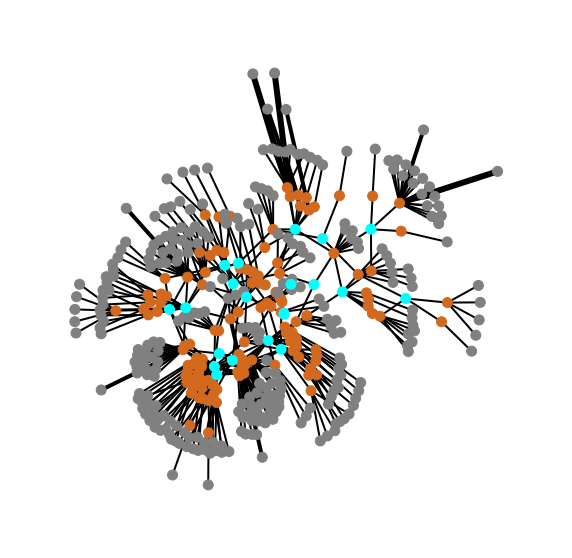

In [4]:
# filePath = r'./0120.csv'

# targetCols = ['공고명', '공사현장', '실수요기관명', '수요기관지역명',
#              '참가수', '개찰순위', '입찰업체명', '입찰업체기업구분명', '낙찰여부', '공공조달분류명']
# df = pd.read_csv(filePath)
# df = df[targetCols]
# # df

# novelCps = [cp for cp in df['입찰업체명'].value_counts().keys() if df['입찰업체명'].value_counts()[cp] < 2]
# # novelCps
# # novelCps는 입찰내역이 1회만 있는 회사
# print("Finished making the novelCps list.\n")

cond_list1 = []
cond_list2 = []
for i in range(len(df)):
    if df.iloc[i]['입찰업체명'] in novelCps:
        cond_list1.append(True)
        if df.iloc[i]['낙찰여부'] == 'Y':
            cond_list2.append(True)
        else:
            cond_list2.append(False)
    else:
        cond_list1.append(False)
        cond_list2.append(False)

df['조건1'] = cond_list1
df['조건2'] = cond_list2

df2 = df.loc[(df['조건2']==True)]

cond_list3 = []
for i in range(len(df)):
    if df.iloc[i]['공고명'] in list(df2['공고명']):
        cond_list3.append(True)
    else:
        cond_list3.append(False)
df['조건3'] = cond_list3

df3 = df.loc[(df['조건3']==False) & (df['조건1']==False)]
# df3
# 조건1, 조건2, 조건3을 통해 입찰내역이 1회인 회사가 낙찰된 경우를 제외. 약 22725(=99896-77171)행 제외.
print("Finished making the final dataframe for constructing a graph.\n")

# 그래프 제작 (이상 구조 검출)
G = nx.Graph()
G.add_nodes_from(list(df3['수요기관지역명'].value_counts().keys()), color='chocolate')
G.add_nodes_from(list(df3['입찰업체명'].value_counts().keys()), color='gray')
G.add_nodes_from(list(df3['공공조달분류명'].value_counts().keys()), color='cyan')

edges_list = []
edges_dict = {}
for i in range(len(df3)):
    if df3.iloc[i]['낙찰여부']=='Y':
        G.add_edge(df3.iloc[i]['수요기관지역명'], df3.iloc[i]['공공조달분류명'])
        edge = (df3.iloc[i]['수요기관지역명'], df3.iloc[i]['입찰업체명'])
        if edge not in edges_list:
            edges_list.append(edge)
            edges_dict[edge] = 1
            G.add_edge(edge[0], edge[1], weight=1)
        else:
            edges_dict[edge] += 1
            G.add_edge(edge[0], edge[1], weight=edges_dict[edge])

cp_nodes   = [node[0] for node in G.nodes(data="color") if node[1]=='gray']
cpDeg_list = list(G.degree(cp_nodes))
cpDeg_list.sort(key=lambda x:-x[1])

remove_nodes = [node[0] for node in cpDeg_list if node[1]==0]
G.remove_nodes_from(remove_nodes)
print("Finished building a graph.\n")

plt.figure(figsize=(10,10))
plt.margins(x=0.1, y=0.1)

# pos = nx.spring_layout(G)
# pos = nx.graphviz_layout(G, prog='twopi', args='')
# pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)
# pos = nx.layout.fruchterman_reingold_layout(G)

nx.draw_networkx_nodes(
        G, pos, node_color=[node[1] for node in G.nodes(data="color")], node_size=100)
        # cmap=plt.cm.Blues, alpha=0.9

nx.draw_networkx_edges(
        G, pos, width=list(np.array([edge[2] for edge in G.edges(data="weight", default=1)])*2))

# nx.draw_networkx_labels(
#         G, pos, font_family='sans-serif', font_color='black', font_size=10, font_weight='bold')

plt.axis('off')
plt.show()

# 입찰 여부 예측

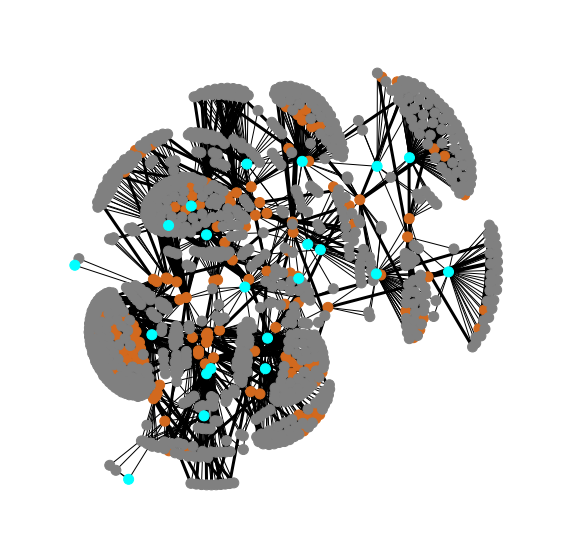

In [5]:
df4 = df3.dropna()
# df4

G2 = nx.Graph()
G2.add_nodes_from(list(df4['수요기관지역명'].value_counts().keys()), color='chocolate')
G2.add_nodes_from(list(df4['입찰업체명'].value_counts().keys()), color='gray')
G2.add_nodes_from(list(df4['공공조달분류명'].value_counts().keys()), color='cyan')

edges_list = []
edges_dict = {}
for i in range(len(df4)):
    if df4.iloc[i]['낙찰여부']=='Y':
        G2.add_edge(df4.iloc[i]['수요기관지역명'], df4.iloc[i]['공공조달분류명'])
        G2.add_edge(df4.iloc[i]['공공조달분류명'], df4.iloc[i]['입찰업체명']) # temp
        edge = (df4.iloc[i]['수요기관지역명'], df4.iloc[i]['입찰업체명'])
        if edge not in edges_list:
            edges_list.append(edge)
            edges_dict[edge] = 3
            G2.add_edge(edge[0], edge[1], weight=3)
        else:
            edges_dict[edge] += 3
            G2.add_edge(edge[0], edge[1], weight=edges_dict[edge])
    elif int(df4.iloc[i]['개찰순위']) < 4:
        G2.add_edge(df4.iloc[i]['수요기관지역명'], df4.iloc[i]['공공조달분류명'])
        G2.add_edge(df4.iloc[i]['공공조달분류명'], df4.iloc[i]['입찰업체명']) # temp
        edge = (df4.iloc[i]['수요기관지역명'], df4.iloc[i]['입찰업체명'])
        if edge not in edges_list:
            edges_list.append(edge)
            edges_dict[edge] = 1
            G2.add_edge(edge[0], edge[1], weight=1)
        else:
            edges_dict[edge] += 1
            G2.add_edge(edge[0], edge[1], weight=edges_dict[edge])
            
cp_nodes   = [node[0] for node in G2.nodes(data="color") if node[1]=='gray']
cpDeg_list = list(G2.degree(cp_nodes))
cpDeg_list.sort(key=lambda x:-x[1])

remove_nodes = [node[0] for node in cpDeg_list if node[1]==0]
G2.remove_nodes_from(remove_nodes)

plt.figure(figsize=(10,10))
plt.margins(x=0.1, y=0.1)

# pos = nx.spring_layout(G2)
# pos = nx.graphviz_layout(G2, prog='twopi', args='')
# pos = nx.circular_layout(G2)
pos = nx.kamada_kawai_layout(G2)
# pos = nx.layout.fruchterman_reingold_layout(G2)

nx.draw_networkx_nodes(
        G2, pos, node_color=[node[1] for node in G2.nodes(data="color")], node_size=100)
        # cmap=plt.cm.Blues, alpha=0.9

nx.draw_networkx_edges(
        G2, pos, width=list(np.array([edge[2] for edge in G2.edges(data="weight", default=1)])*1))

# nx.draw_networkx_labels(
#         G2, pos, font_family='sans-serif', font_color='black', font_size=10, font_weight='bold')

plt.axis('off')
plt.show()

In [6]:
nodes1s = [node[0] for node in G2.nodes(data="color") if node[1]=='chocolate']
nodes2s = [node[0] for node in G2.nodes(data="color") if node[1]=='gray']
nodes1s = random.sample(nodes1s, 5)
nodes2s = random.sample(nodes2s, 10)

nodePairs = []
for node1 in nodes1s:
    for node2 in nodes2s:
        nodePairs.append((node1, node2))

preds = nx.jaccard_coefficient(G2, nodePairs)
#preds = nx.common_neighbor_centrality(G2, nodePairs)
for u, v, p in preds:
    print(f"({u}, {v}) -> {p}")

(충청남도 태안군, 주식회사 송산) -> 0.0
(충청남도 태안군, 주식회사미림실내건축) -> 0.0
(충청남도 태안군, 초전산업 주식회사) -> 0.0
(충청남도 태안군, 서림종합건설 주식회사) -> 0.0
(충청남도 태안군, 미리벌종합건설(주)) -> 0.0
(충청남도 태안군, 주식회사 소나무) -> 0.0
(충청남도 태안군, 대광건설전력(주)) -> 0.0
(충청남도 태안군, 삼보건설 주식회사) -> 0.0
(충청남도 태안군, 원산건설주식회사) -> 0.0
(충청남도 태안군, 명문건설 주식회사) -> 0.0
(경상남도 진주시, 주식회사 송산) -> 0.0
(경상남도 진주시, 주식회사미림실내건축) -> 0.09090909090909091
(경상남도 진주시, 초전산업 주식회사) -> 0.0
(경상남도 진주시, 서림종합건설 주식회사) -> 0.0
(경상남도 진주시, 미리벌종합건설(주)) -> 0.0
(경상남도 진주시, 주식회사 소나무) -> 0.0
(경상남도 진주시, 대광건설전력(주)) -> 0.09090909090909091
(경상남도 진주시, 삼보건설 주식회사) -> 0.0
(경상남도 진주시, 원산건설주식회사) -> 0.0
(경상남도 진주시, 명문건설 주식회사) -> 0.0
(경기도 부천시 오정구, 주식회사 송산) -> 0.0
(경기도 부천시 오정구, 주식회사미림실내건축) -> 0.0
(경기도 부천시 오정구, 초전산업 주식회사) -> 0.0
(경기도 부천시 오정구, 서림종합건설 주식회사) -> 0.0
(경기도 부천시 오정구, 미리벌종합건설(주)) -> 0.0
(경기도 부천시 오정구, 주식회사 소나무) -> 0.0
(경기도 부천시 오정구, 대광건설전력(주)) -> 0.0
(경기도 부천시 오정구, 삼보건설 주식회사) -> 0.14285714285714285
(경기도 부천시 오정구, 원산건설주식회사) -> 0.0
(경기도 부천시 오정구, 명문건설 주식회사) -> 0.0
(경기도 성남시 분당구, 주식회사 송산) -> 0.0
(경기도 성남시 분당구, 주식회사미림실내

# 하단은 연습

In [20]:
novelCps = [cp for cp in df['입찰업체명'].value_counts().keys() if df['입찰업체명'].value_counts()[cp] < 2]
novelCps 

['강북냉열기',
 '오피뉴',
 '주식회사 지노디자인',
 '주식회사 구티인테리어',
 '주식회사 데코빌닷엘',
 '성한이엔지 유한회사',
 '주식회사 지오건축',
 '(주)영도건설',
 '주식회사 대한미술공사',
 '성강건설(주)',
 '주식회사 우노디자인',
 '주식회사 엔터',
 '주식회사 이끌림디자인',
 '주식회사 콕스디자인',
 '주식회사 다인이엔지',
 '(주)나다아이디',
 '일신산업',
 '주식회사  삼진에이치에스',
 '삼성플랜트',
 '주식회사 나래피움',
 '주식회사 성복개발',
 '월성설비(주)',
 '서영정공',
 '(주)예다지',
 '주식회사 디자인메이',
 '주식회사 명인이앤씨',
 '주식회사 디자인포',
 '주식회사 제이앤텍',
 '주식회사 지오스웰디자인',
 '주식회사 디씨엔에스',
 '주식회사 올뉴아이디',
 '주식회사 임정',
 '주식회사 미래디자인',
 '주호디자인 주식회사',
 '(주) 경현산업',
 '주식회사 용원테크',
 '신한상사 (주)',
 '주식회사 해인플랜트',
 '(주)다연건설',
 '주식회사 디큐엘',
 '먼들엔티 주식회사',
 '주식회사 가든',
 '(주)한영기업',
 '주식회사 삼덕',
 '주식회사 한산',
 '(주)용성이엔지',
 '주식회사 대성종합건설',
 '주식회사 지율디자인',
 '세진아이디 주식회사',
 '주식회사 우리아이앤지',
 '그린공조시스템(주)',
 '디자인윤 주식회사',
 '동양이앤씨 주식회사',
 '삼중테크건설주식회사',
 '주식회사 세연시스템',
 '주식회사 진홍이엔지',
 '주식회사 우주시스템',
 '주식회사 미공디자인',
 '(주)고려기획',
 '명성기업(주)',
 '주식회사 바우드 유니온',
 '(주)공간수장',
 '주식회사경원이엔지',
 '주식회사 엘테크',
 '주식회사 예일',
 '(주)에스디에이',
 '주식회사 여미지건축',
 '(주) 온양',
 '주식회사 큐브앤내장',
 '세아건설(주)',
 '한상조경 주식회사',
 '동희플러스 주식회사',
 '주식회사 아이피건축디자

In [24]:
cond_list1 = []
cond_list2 = []
for i in range(len(df)):
    if df.iloc[i]['입찰업체명'] in novelCps:
        cond_list1.append(True)
        if df.iloc[i]['낙찰여부'] == 'Y':
            cond_list2.append(True)
        else:
            cond_list2.append(False)
    else:
        cond_list1.append(False)
        cond_list2.append(False)

df['조건1'] = cond_list1
df['조건2'] = cond_list2

In [32]:
df2 = df.loc[(df['조건2']==True)]

cond_list3 = []
for i in range(len(df)):
    if df.iloc[i]['공고명'] in list(df2['공고명']):
        cond_list3.append(True)
    else:
        cond_list3.append(False)
df['조건3'] = cond_list3
df

,공고명,공사현장,실수요기관명,수요기관지역명,참가수,개찰순위,입찰업체명,입찰업체기업구분명,낙찰여부,공공조달분류명,조건1,조건2,조건3
0,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,1.0,주식회사 덕동산업,중소기업,N,소방시설공사,False,False,False
1,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,2.0,우경건설 주식회사,중견기업,N,소방시설공사,False,False,False
2,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,3.0,주식회사 용원테크,중소기업,N,소방시설공사,True,False,False
3,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,4.0,주식회사 제일소방,중소기업,N,소방시설공사,True,False,False
4,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,5.0,(주)대원소방,중소기업,N,소방시설공사,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99891,(국고 혁신지원사업)동부캠퍼스 개방형 학습공간 구축 실내건축 공사,울산광역시 동구,울산과학대학산학협력단,울산광역시 동구,5,1.0,거송건설 (주),중소기업,Y,실내건축공사,True,True,True
99892,(국고 혁신지원사업)동부캠퍼스 개방형 학습공간 구축 실내건축 공사,울산광역시 동구,울산과학대학산학협력단,울산광역시 동구,5,2.0,경원건업(주),중소기업,N,실내건축공사,True,False,True
99893,(국고 혁신지원사업)동부캠퍼스 개방형 학습공간 구축 실내건축 공사,울산광역시 동구,울산과학대학산학협력단,울산광역시 동구,5,3.0,주식회사 서울에스앤디,중소기업,N,실내건축공사,False,False,True
99894,(국고 혁신지원사업)동부캠퍼스 개방형 학습공간 구축 실내건축 공사,울산광역시 동구,울산과학대학산학협력단,울산광역시 동구,5,4.0,주식회사 이상씨엔씨,중소기업,N,실내건축공사,True,False,True


In [38]:
df3 = df.loc[(df['조건3']==False) & (df['조건1']==False)]
df3

,공고명,공사현장,실수요기관명,수요기관지역명,참가수,개찰순위,입찰업체명,입찰업체기업구분명,낙찰여부,공공조달분류명,조건1,조건2,조건3
0,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,1.0,주식회사 덕동산업,중소기업,N,소방시설공사,False,False,False
1,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,2.0,우경건설 주식회사,중견기업,N,소방시설공사,False,False,False
5,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,6.0,에스에이치건설 주식회사,중소기업,N,소방시설공사,False,False,False
7,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,8.0,지음이엔아이 주식회사,중소기업,N,소방시설공사,False,False,False
8,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,9.0,주식회사 엘케이엔지니어링,중소기업,N,소방시설공사,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99878,2021년 전남도립대학교 전문대학혁신지원사업 환경개선_메타버스 교육관 구축,전라남도 담양군,전남도립대학산학협력단,전라남도 담양군,108,NaN,아이엘아이앤디(주),중소기업,N,실내건축공사,False,False,False
99879,2021년 전남도립대학교 전문대학혁신지원사업 환경개선_메타버스 교육관 구축,전라남도 담양군,전남도립대학산학협력단,전라남도 담양군,108,NaN,주식회사 디지에스건축,중소기업,N,실내건축공사,False,False,False
99880,2021년 전남도립대학교 전문대학혁신지원사업 환경개선_메타버스 교육관 구축,전라남도 담양군,전남도립대학산학협력단,전라남도 담양군,108,NaN,에이원산업(주),중소기업,N,실내건축공사,False,False,False
99881,2021년 전남도립대학교 전문대학혁신지원사업 환경개선_메타버스 교육관 구축,전라남도 담양군,전남도립대학산학협력단,전라남도 담양군,108,NaN,주식회사 일진건설,중소기업,N,실내건축공사,False,False,False


In [48]:
G = nx.Graph()
G.add_nodes_from(list(df3['수요기관지역명'].value_counts().keys()), color='chocolate')
G.add_nodes_from(list(df3['입찰업체명'].value_counts().keys()), color='gray')
G.add_nodes_from(list(df3['공공조달분류명'].value_counts().keys()), color='cyan')

edges_list = []
edges_dict = {}
for i in range(len(df3)):
    if df3.iloc[i]['낙찰여부']=='Y':
        G.add_edge(df3.iloc[i]['수요기관지역명'], df3.iloc[i]['공공조달분류명'])
        edge = (df3.iloc[i]['수요기관지역명'], df3.iloc[i]['입찰업체명'])
        if edge not in edges_list:
            edges_list.append(edge)
            edges_dict[edge] = 1
            G.add_edge(edge[0], edge[1], weight=1)
        else:
            edges_dict[edge] += 1
            G.add_edge(edge[0], edge[1], weight=edges_dict[edge])

In [69]:
cp_nodes   = [node[0] for node in G.nodes(data="color") if node[1]=='gray']
cpDeg_list = list(G.degree(cp_nodes))
cpDeg_list.sort(key=lambda x:-x[1])

remove_nodes = [node[0] for node in cpDeg_list if node[1]==0]
G.remove_nodes_from(remove_nodes)

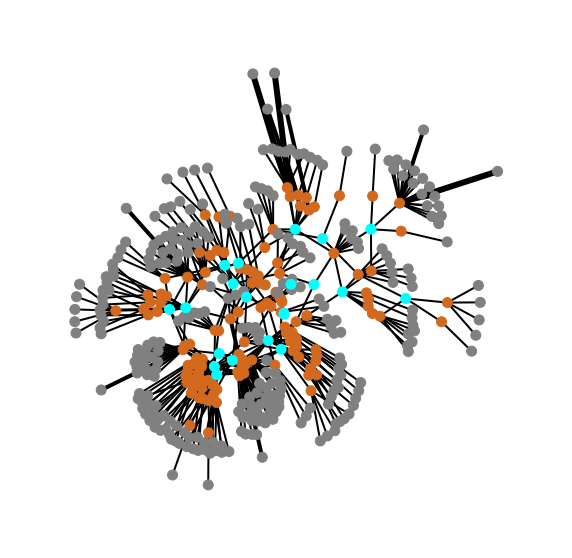

In [86]:
plt.figure(figsize=(10,10))
plt.margins(x=0.1, y=0.1)

# pos = nx.spring_layout(G)
# pos = nx.graphviz_layout(G, prog='twopi', args='')
# pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)
# pos = nx.layout.fruchterman_reingold_layout(G)

nx.draw_networkx_nodes(
        G, pos, node_color=[node[1] for node in G.nodes(data="color")], node_size=100)
        # cmap=plt.cm.Blues, alpha=0.9

nx.draw_networkx_edges(
        G, pos, width=list(np.array([edge[2] for edge in G.edges(data="weight", default=1)])*2))

# nx.draw_networkx_labels(
#         G, pos, font_family='sans-serif', font_color='black', font_size=10, font_weight='bold'
#     )
plt.axis('off')
plt.show()

In [68]:
df4 = df3.dropna()
df4

,공고명,공사현장,실수요기관명,수요기관지역명,참가수,개찰순위,입찰업체명,입찰업체기업구분명,낙찰여부,공공조달분류명,조건1,조건2,조건3
0,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,1.0,주식회사 덕동산업,중소기업,N,소방시설공사,False,False,False
1,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,2.0,우경건설 주식회사,중견기업,N,소방시설공사,False,False,False
5,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,6.0,에스에이치건설 주식회사,중소기업,N,소방시설공사,False,False,False
7,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,8.0,지음이엔아이 주식회사,중소기업,N,소방시설공사,False,False,False
8,하남시 감일공공복합청사 건립 소방공사,경기도,경기도 하남시,경기도 하남시,884,9.0,주식회사 엘케이엔지니어링,중소기업,N,소방시설공사,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99473,적층제조지원 공간조성 건축 공사,대전광역시 유성구,재단법인 대전테크노파크,대전광역시 유성구,326,25.0,재현건설산업 주식회사,중소기업,N,실내건축공사,False,False,False
99477,적층제조지원 공간조성 건축 공사,대전광역시 유성구,재단법인 대전테크노파크,대전광역시 유성구,326,29.0,무진종합건설 주식회사,중소기업,N,실내건축공사,False,False,False
99480,적층제조지원 공간조성 건축 공사,대전광역시 유성구,재단법인 대전테크노파크,대전광역시 유성구,326,32.0,주식회사 새빛디자인,중소기업,N,실내건축공사,False,False,False
99775,2021년 전남도립대학교 전문대학혁신지원사업 환경개선_메타버스 교육관 구축,전라남도 담양군,전남도립대학산학협력단,전라남도 담양군,108,1.0,주식회사 보광,중소기업,Y,실내건축공사,False,False,False


In [95]:
G2 = nx.Graph()
G2.add_nodes_from(list(df4['수요기관지역명'].value_counts().keys()), color='chocolate')
G2.add_nodes_from(list(df4['입찰업체명'].value_counts().keys()), color='gray')
G2.add_nodes_from(list(df4['공공조달분류명'].value_counts().keys()), color='cyan')

edges_list = []
edges_dict = {}
for i in range(len(df4)):
    if df4.iloc[i]['낙찰여부']=='Y':
        G2.add_edge(df4.iloc[i]['수요기관지역명'], df4.iloc[i]['공공조달분류명'])
        G2.add_edge(df4.iloc[i]['공공조달분류명'], df4.iloc[i]['입찰업체명']) # temp
        edge = (df4.iloc[i]['수요기관지역명'], df4.iloc[i]['입찰업체명'])
        if edge not in edges_list:
            edges_list.append(edge)
            edges_dict[edge] = 3
            G2.add_edge(edge[0], edge[1], weight=3)
        else:
            edges_dict[edge] += 3
            G2.add_edge(edge[0], edge[1], weight=edges_dict[edge])
    elif int(df4.iloc[i]['개찰순위']) < 4:
        G2.add_edge(df4.iloc[i]['수요기관지역명'], df4.iloc[i]['공공조달분류명'])
        G2.add_edge(df4.iloc[i]['공공조달분류명'], df4.iloc[i]['입찰업체명']) # temp
        edge = (df4.iloc[i]['수요기관지역명'], df4.iloc[i]['입찰업체명'])
        if edge not in edges_list:
            edges_list.append(edge)
            edges_dict[edge] = 1
            G2.add_edge(edge[0], edge[1], weight=1)
        else:
            edges_dict[edge] += 1
            G2.add_edge(edge[0], edge[1], weight=edges_dict[edge])
            
cp_nodes   = [node[0] for node in G2.nodes(data="color") if node[1]=='gray']
cpDeg_list = list(G2.degree(cp_nodes))
cpDeg_list.sort(key=lambda x:-x[1])

remove_nodes = [node[0] for node in cpDeg_list if node[1]==0]
G2.remove_nodes_from(remove_nodes)

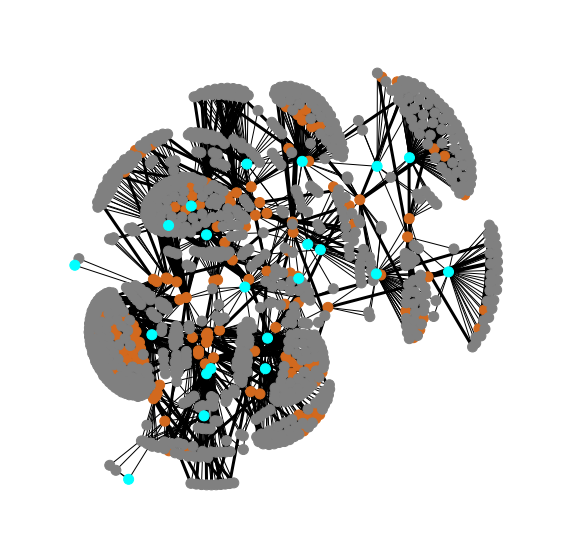

In [96]:
plt.figure(figsize=(10,10))
plt.margins(x=0.1, y=0.1)

# pos = nx.spring_layout(G2)
# pos = nx.graphviz_layout(G2, prog='twopi', args='')
# pos = nx.circular_layout(G2)
pos = nx.kamada_kawai_layout(G2)
# pos = nx.layout.fruchterman_reingold_layout(G2)

nx.draw_networkx_nodes(
        G2, pos, node_color=[node[1] for node in G2.nodes(data="color")], node_size=100)
        # cmap=plt.cm.Blues, alpha=0.9

nx.draw_networkx_edges(
        G2, pos, width=list(np.array([edge[2] for edge in G2.edges(data="weight", default=1)])*1))

# nx.draw_networkx_labels(
#         G2, pos, font_family='sans-serif', font_color='black', font_size=10, font_weight='bold')

plt.axis('off')
plt.show()

In [128]:
nodes1s = [node[0] for node in G2.nodes(data="color") if node[1]=='chocolate']
nodes2s = [node[0] for node in G2.nodes(data="color") if node[1]=='gray']
nodes1s = random.sample(nodes1s, 5)
nodes2s = random.sample(nodes2s, 10)

nodePairs = []
for node1 in nodes1s:
    for node2 in nodes2s:
        nodePairs.append((node1, node2))

preds = nx.jaccard_coefficient(G2, nodePairs)
#preds = nx.common_neighbor_centrality(G2, nodePairs)
for u, v, p in preds:
    print(f"({u}, {v}) -> {p}")

(전라남도 해남군, 국토기업 주식회사) -> 0.025
(전라남도 해남군, 점동지하수) -> 0.0
(전라남도 해남군, 성원산전주식회사) -> 0.0
(전라남도 해남군, 아성글로벌주식회사) -> 0.0
(전라남도 해남군, 정의종합건설 주식회사) -> 0.0
(전라남도 해남군, 미성건설주식회사) -> 0.0
(전라남도 해남군, 투원퓨어텍 주식회사) -> 0.025
(전라남도 해남군, 주식회사 다미조경) -> 0.0
(전라남도 해남군, 천지건설 주식회사) -> 0.025
(전라남도 해남군, 세원전설 주식회사) -> 0.0
(경기도 화성시, 국토기업 주식회사) -> 0.06666666666666667
(경기도 화성시, 점동지하수) -> 0.0
(경기도 화성시, 성원산전주식회사) -> 0.0
(경기도 화성시, 아성글로벌주식회사) -> 0.0
(경기도 화성시, 정의종합건설 주식회사) -> 0.0
(경기도 화성시, 미성건설주식회사) -> 0.06666666666666667
(경기도 화성시, 투원퓨어텍 주식회사) -> 0.06666666666666667
(경기도 화성시, 주식회사 다미조경) -> 0.0
(경기도 화성시, 천지건설 주식회사) -> 0.06666666666666667
(경기도 화성시, 세원전설 주식회사) -> 0.0
(서울특별시 노원구, 국토기업 주식회사) -> 0.0
(서울특별시 노원구, 점동지하수) -> 0.0
(서울특별시 노원구, 성원산전주식회사) -> 0.0
(서울특별시 노원구, 아성글로벌주식회사) -> 0.0
(서울특별시 노원구, 정의종합건설 주식회사) -> 0.0
(서울특별시 노원구, 미성건설주식회사) -> 0.0
(서울특별시 노원구, 투원퓨어텍 주식회사) -> 0.0
(서울특별시 노원구, 주식회사 다미조경) -> 0.0
(서울특별시 노원구, 천지건설 주식회사) -> 0.0
(서울특별시 노원구, 세원전설 주식회사) -> 0.0
(부산광역시 해운대구, 국토기업 주식회사) -> 0.0
(부산광역시 해운대구, 점동지하수) -> 0.0
(부산광역시 해운대구